# Cluster features using unsupervised learning
- Requires 'data/handlabeled_vectors_1k.csv'), with columns:
    - [0] is old index, ignore.
    - [1] is id 
    - [2] is original category
    - [3] is hand category
    - [next 300] are text features
    - [next 300] are image features

In [61]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster, fclusterdata
from sklearn.model_selection import train_test_split

# Plotting tools
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import itertools

# Import data

In [37]:
df = pd.read_csv('data/handlabeled_vectors_1k.csv')
id_vec = df[df.columns[1]]
category_vec = df[df.columns[3]]
text_vec = df[df.columns[4:304]]
image_vec = df[df.columns[304:604]]
combined_vec = df[df.columns[4:604]]

## Split data set into two, we'll use 1/2 for unsupervised clustering, and 1/2 for supervised classification to test the clusters

In [38]:
X_set1, X_set2, y_set1, y_set2 = train_test_split(combined_vec, category_vec, random_state=0, test_size=0.5)

# Unsupervised Hierarchical Clustering

In [39]:
# This could be functions
class Run_HC():
    # Generate the linkage matrix
    def __init__(self, data, method, metric):
        self.Z = linkage(data, method=method, metric=metric)
        c, coph_dists = cophenet(self.Z, pdist(data, metric=metric))
        print("Cophenetic Correlation Coefficient: ", c)
        '''
        CCC compares the actual pairwise distances of all samples to those implied by the hierarchical clustering. 
        The closer the value is to 1, the better the clustering preserves the original distances."
        '''
    # Calculate and show the full dendrogram
    def full_dendrogram(self):
        plt.figure(figsize=(25, 10))
        plt.title('Full Hierarchical Clustering Dendrogram', size=25)
        plt.xlabel('Index')
        plt.ylabel('Distance')
        dendrogram(
            self.Z,
            leaf_rotation=90.,  # rotates the x axis labels
            leaf_font_size=8.);  # font size for the x axis labels
        plt.show()
        
    # Calculate and show the partial dendrogram
    def partial_dendrogram(self, p=30, ylim=(.45,.85)):
        plt.figure(figsize=(25, 10))
        plt.title('Partial Hierarchical Clustering Dendrogram', size=25)
        plt.xlabel('Index')
        plt.ylabel('Distance')
        dendrogram(
            self.Z,
            truncate_mode = 'lastp',
            p=p,
            leaf_rotation=90,
            leaf_font_size=12);
        ax=plt.gca()
        ax.set_ylim(ylim)
        
    # Elbow method
    # TODO: describe this
    def plot_elbow(self):
        plt.figure()
        plt.title('Elbow Plot', size=15)
        last = self.Z[-100:, 2]
        last_rev = last[::-1]
        idxs = np.arange(1, len(last) + 1)
        plt.plot(idxs, last_rev)
        
        # 2nd derivative of the distances to see if there's an "elbow"
        acceleration = np.diff(last, 2)
        acceleration_rev = acceleration[::-1]
        plt.plot(idxs[:-2] +1, acceleration_rev)
        plt.show()
        
    def plot_scatcats(self, X, max_d=.5):
        plt.figure()
        clusters = fcluster(self.Z, max_d, criterion='distance')
        pca_embed = PCA(n_components=2,random_state=0).fit_transform(X)
        pcawithlabels = np.hstack((pca_embed, np.reshape(pd.factorize(clusters)[0], newshape=(X.shape[0],1)) ))
        A = pcawithlabels
        A = A[np.random.randint(A.shape[0], size=500), :]
        colors = pd.factorize(A[:,2])
        plt.scatter(A[:,0], A[:,1], c=A[:,2], cmap='nipy_spectral') ;
        plt.title('Category Visualization: ' + str(len(np.unique(clusters))) +' categories.', size=15)
        plt.figure()
        plt.hist(clusters)
        plt.title('Histogram of clusters', size=15)
        return fcluster(self.Z, max_d, criterion='distance')
        

## Using Cosine

Cophenetic Correlation Coefficient:  0.75954827161


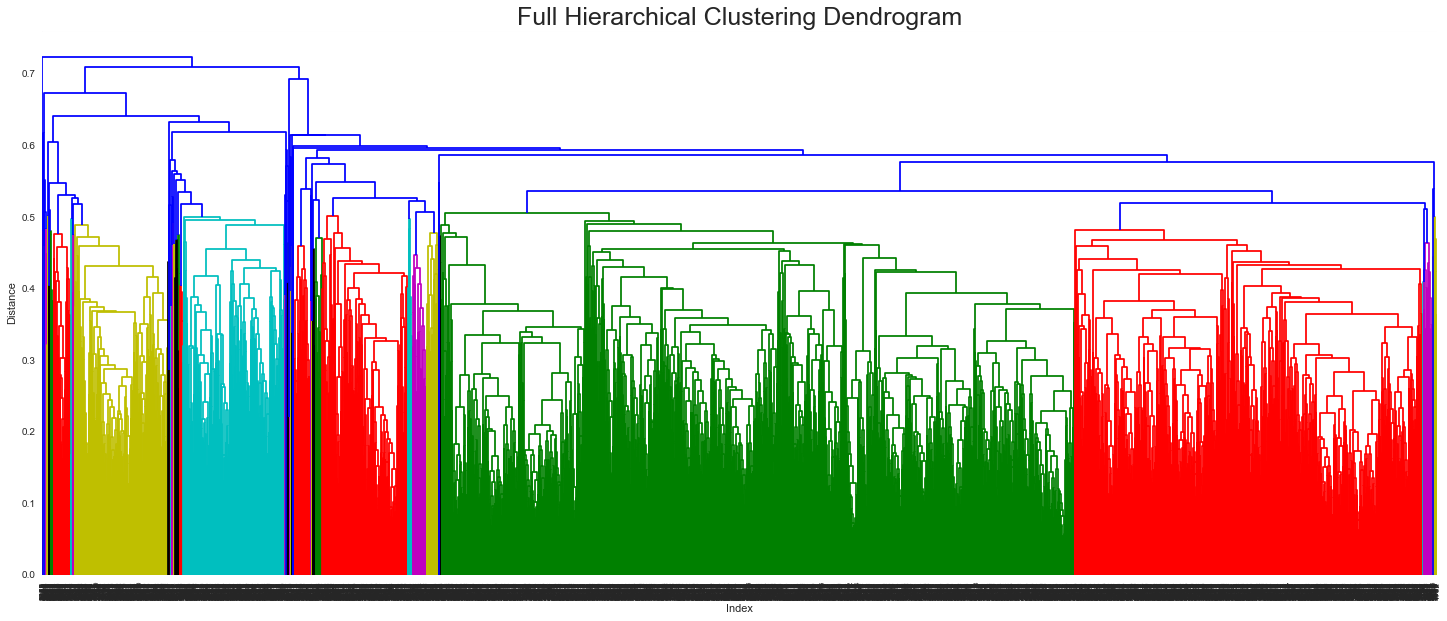

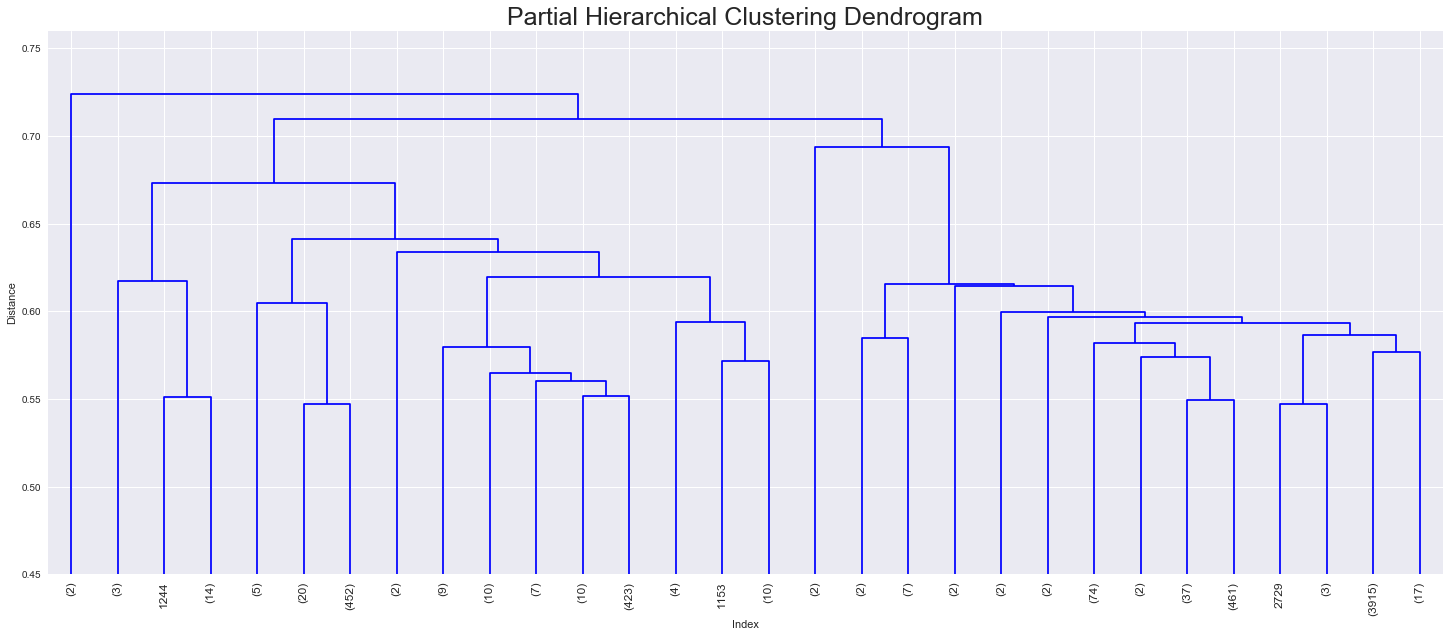

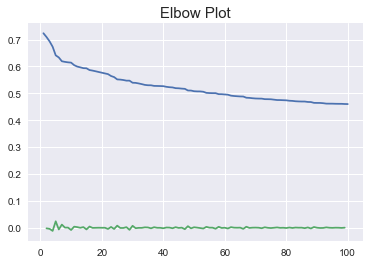

array([13, 53, 52, ..., 51, 45, 24], dtype=int32)

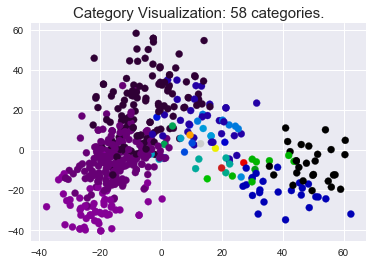

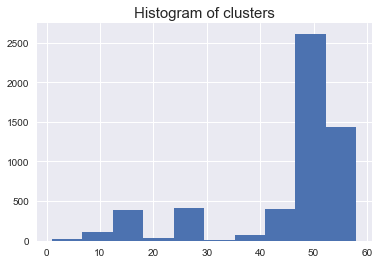

In [40]:
Z_cos = Run_HC(X_set1, "average", "cosine")
Z_cos.full_dendrogram()
Z_cos.partial_dendrogram(p=30, ylim=(.45,.76) )
Z_cos.plot_elbow()
Z_cos.plot_scatcats(X_set1, max_d=.5)


Although cosine can be useful with these high-D features (for comparing similarity), as a clustering metric we're not separating clusters very effectively (as we can see from the low CCC value and the very unbalanced histogram, for example). Try euclidean.


## Using Euclidean

Cophenetic Correlation Coefficient:  0.497323889229


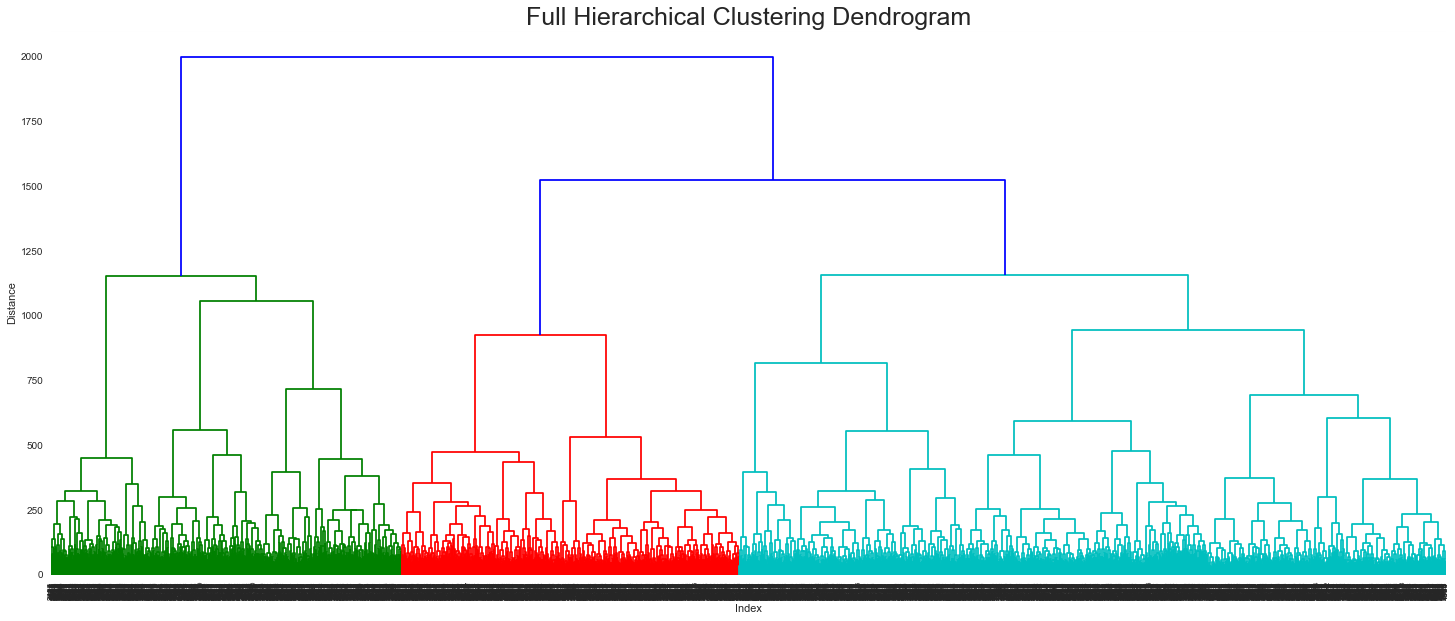

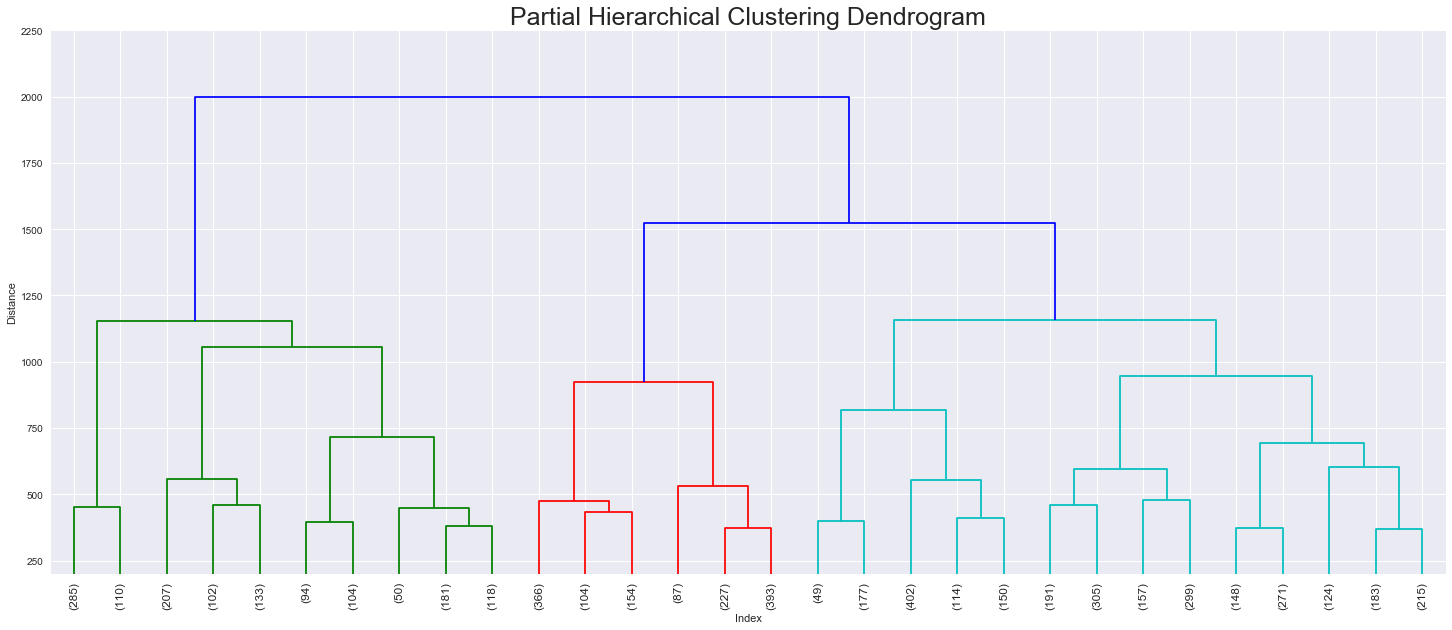

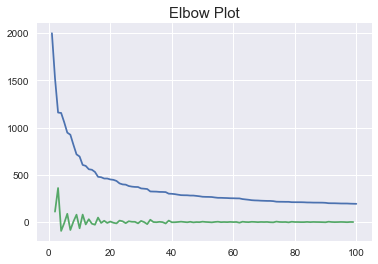

array([ 3,  8, 15, ..., 11,  4,  1], dtype=int32)

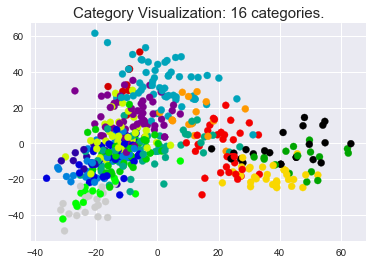

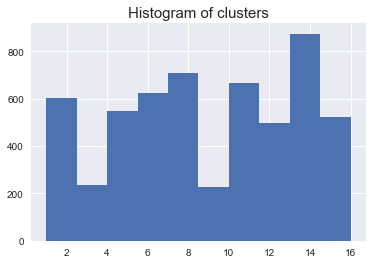

In [41]:
Z_euclidean = Run_HC(X_set1, "ward", "euclidean")
Z_euclidean.full_dendrogram()
Z_euclidean.partial_dendrogram(p=30, ylim=(200,2250)  )
Z_euclidean.plot_elbow()
Z_euclidean.plot_scatcats(X_set1, max_d=500)

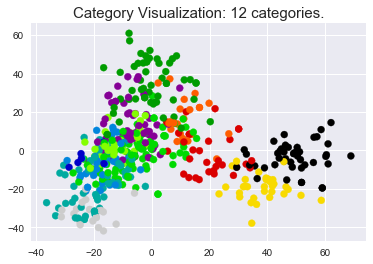

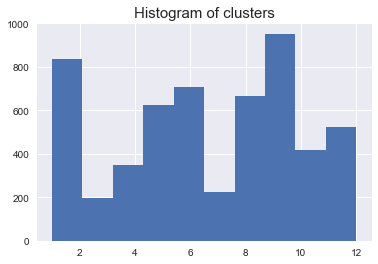

In [52]:
clusters12 = Z_euclidean.plot_scatcats(X_set1, max_d=600)

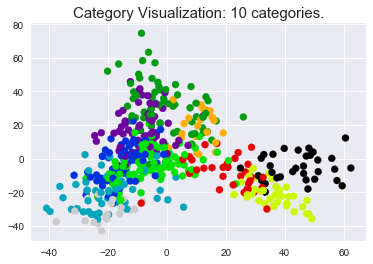

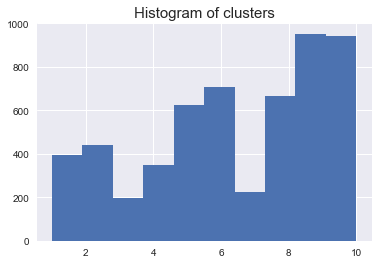

In [53]:
clusters10 = Z_euclidean.plot_scatcats(X_set1, max_d=700)

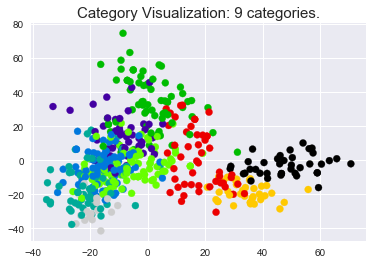

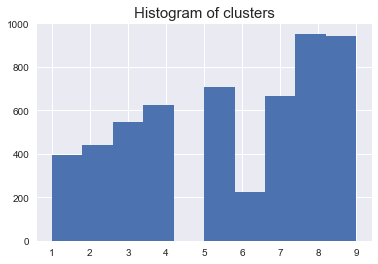

In [44]:
clusters = Z_euclidean.plot_scatcats(X_set1, max_d=750)

# Validate clustering

In [54]:
X = X_set1
y_pred = clusters10
y_actual = y_set1 

### Standard Clustering Metrics
On emergent categories on combined data (using the same data on which the model was fit)

In [55]:
# Compare similarity between two labeling schemes. 0 is random, 1 is identical groupings.
print('Adjusted Rand index: ' + str(metrics.adjusted_rand_score(y_actual, y_pred)))

# Measure the agreement of the two assignments, ignoring permutations
print('Adjusted mutual information: ' + str(metrics.adjusted_mutual_info_score(y_actual, y_pred)))

# Homogeneity: Each cluster contains only members of a single class
print('Homogeneity score: ' + str(metrics.homogeneity_score(y_actual, y_pred)))

# Completeness: All members of a given class are assigned to the same cluster
print('Completeness score: ' + str(metrics.completeness_score(y_actual, y_pred)))

# "V-measure", aka harmonic mean
print('V-Measure: ' + str(metrics.v_measure_score(y_actual, y_pred)))

# Fowlkes-Mallows score: is the geometric mean of the pairwise precision and recall
print('FMI: ' + str(metrics.fowlkes_mallows_score(y_actual, y_pred)))


Adjusted Rand index: 0.30504727106
Adjusted mutual information: 0.437141296818
Homogeneity score: 0.43907250437
Completeness score: 0.480792547981
V-Measure: 0.45898642977
FMI: 0.381408180484


### Validate with hold-out set
##### Do we make classification accuracy better? That's the client's real goal.

In [73]:
X1 = X_set1
y1_pred = clusters10
y1_actual = y_set1 

In [56]:
def do_logreg(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=0)
    lr = LogisticRegression(random_state=1)
    lr.fit(X_train, y_train)
    lr_y_pred = lr.predict(X_test)
    return(accuracy_score(y_test, lr_y_pred))

#### For text + image

In [64]:
# For Text + Image

# Logistic regression results with original categories
print('Accuracy on original, train set = ' + str(do_logreg(X1, y1_actual)))

# and with emergent categories:
print('Accuracy on emergent, train set = ' + str(do_logreg(X1, y1_pred)))

Accuracy on original, train set = 0.770909090909
Accuracy on emergent, train set = 0.877818181818


In [75]:
# But we need to do logreg on new categories.
# In order to assign new categories, we need to look at the newly predicted categories 

## Look at what's in the categories

In [92]:
len(np.unique(clusters10))

10

In [111]:
# c = y1_actual[clusters10==1]
# c.value_counts()